# PetFinder.my - Pawpularity Contest

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kstest
from tqdm.notebook import tqdm
from PIL import Image
import imageio
import math
import warnings
import imagehash

# Activate pandas progress apply bar
tqdm.pandas()

In [40]:
train = pd.read_csv('data/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('data/petfinder-pawpularity-score/test.csv')

In [41]:
# Add image path to Train
def get_image_file_path(image_id):
    return f'data/petfinder-pawpularity-score/train/{image_id}.jpg'

train['file_path'] = train['Id'].apply(get_image_file_path)

In [42]:
train.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                           file_path  
0  data/petfinder-pawpularity-score/train/0007de1...  
1  data/petfinder-pawpularity-score/train/0009c66...  
2  data/petfinder-pawpularity-score/train/0013fd9...  
3  data/petfinder-pawpularity-score/train/0018df3...  
4  data/petfinder-pawpularity-score/train/001dc95...

# EDA for Metadata

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 15 columns):
Id               9912 non-null object
Subject Focus    9912 non-null int64
Eyes             9912 non-null int64
Face             9912 non-null int64
Near             9912 non-null int64
Action           9912 non-null int64
Accessory        9912 non-null int64
Group            9912 non-null int64
Collage          9912 non-null int64
Human            9912 non-null int64
Occlusion        9912 non-null int64
Info             9912 non-null int64
Blur             9912 non-null int64
Pawpularity      9912 non-null int64
file_path        9912 non-null object
dtypes: int64(13), object(2)
memory usage: 1.1+ MB


In [7]:
#Check missing value
train.isnull().sum()

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
file_path        0
dtype: int64

Pawpularity Statistics
count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64


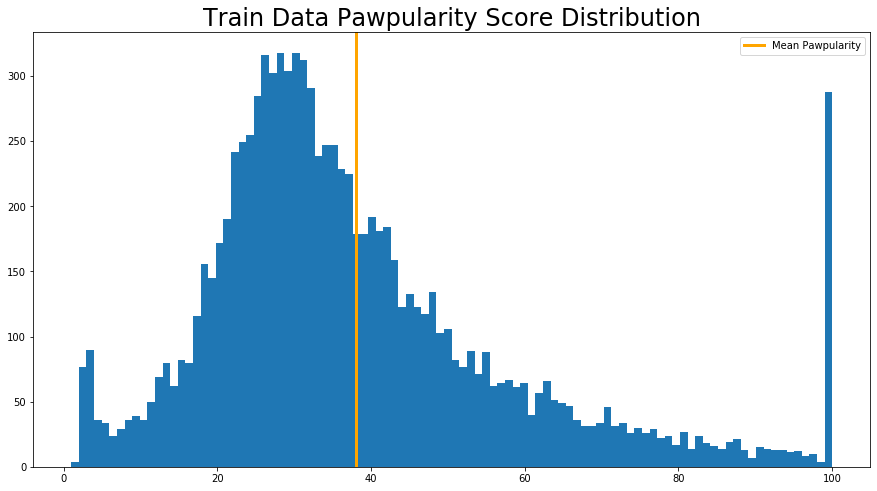

In [7]:
# Pawpularity Score Distribution
print('Pawpularity Statistics')
print(train['Pawpularity'].describe())
plt.figure(figsize=(15,8))
plt.title('Train Data Pawpularity Score Distribution', size=24)
plt.hist(train['Pawpularity'], bins=100)
plt.axvline(train['Pawpularity'].mean(), c='orange', ls='-', lw=3, label="Mean Pawpularity")
plt.legend()
#plt.show()
plt.savefig('fig1_1.pdf')

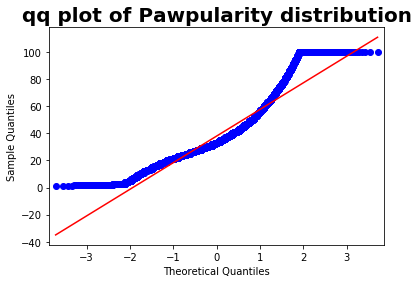

In [8]:
# Use qq plot check the normality of the Pawpularity distribution
qqplot(train['Pawpularity'], line='r')
plt.title('qq plot of Pawpularity distribution', 
          fontsize=20, fontweight='bold')
#plt.show()
plt.savefig('fig1_2.pdf')

In [9]:
# Kolmogorov-Smirnov test 
stat, p = kstest(train['Pawpularity'],'norm')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print(f'Sample follows Gaussian distribution (fail to reject H0 at {int(alpha*100)}% test level)')
else:
    print(f'Sample does not follow Gaussian distribution (reject H0 at {int(alpha*100)}% test level)')

Statistics=0.990, p=0.000
Sample does not follow Gaussian distribution (reject H0 at 5% test level)


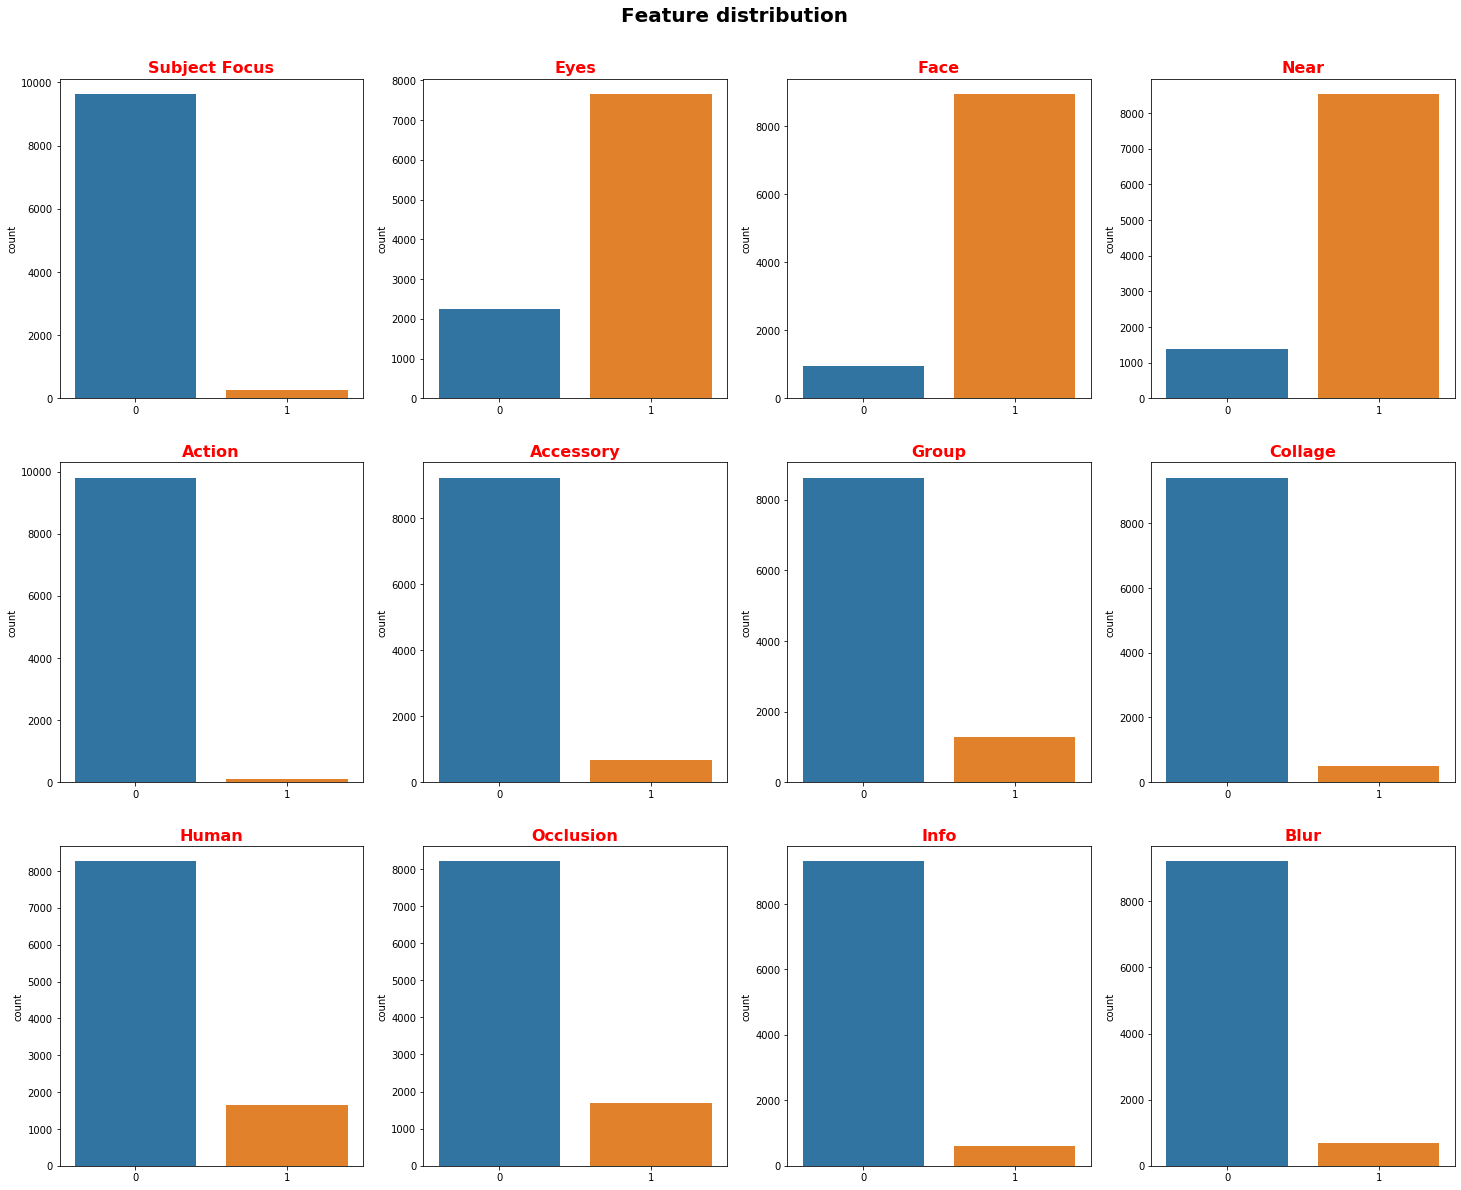

In [10]:
#Distribution of features
predictor = train.columns[1:13]
fig = plt.figure(figsize=(25,20))
for idx, colname in enumerate(predictor):
    ax = plt.subplot(3,4,idx+1)
    sns.countplot(data=train, x=colname, ax=ax)
    ax.set_xlabel(None)
    ax.set_title(colname, fontweight='bold', fontsize = 16, color="red")

plt.suptitle("Feature distribution", y=0.93,
             fontsize=20, fontweight='bold')
#plt.show() 
plt.savefig('fig1_3.pdf')

<Figure size 432x288 with 0 Axes>

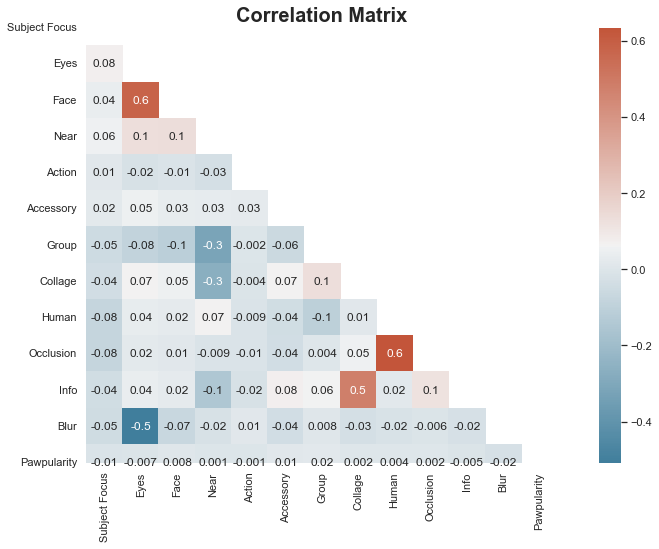

In [11]:
predictor = train.columns[1:14]

corr_matrix = train[predictor].corr()
fig = plt.figure()
plt.figure(figsize=(15,8))
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap=cmap, 
            mask=mask, square=True)
plt.title('Correlation Matrix', fontsize=20, fontweight='bold')
#plt.show()
plt.savefig('fig1_4.pdf')

In [8]:
#Use VIF to check the multicollinearity
predictor = train.columns[1:13]

print(predictor)

corr_matrix = train[predictor].corr()

from numpy.linalg import inv
inv_corr = inv(corr_matrix)

vif_data = pd.DataFrame()
vif_data["feature"] = predictor
vif_data["VIF"] = inv_corr.diagonal()
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data

Index(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
       'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],
      dtype='object')


feature       VIF
1            Eyes  2.307956
8           Human  1.723615
9       Occlusion  1.721186
2            Face  1.712161
11           Blur  1.510249
7         Collage  1.392512
10           Info  1.328935
3            Near  1.213886
6           Group  1.142908
0   Subject Focus  1.019446
5       Accessory  1.018282
4          Action  1.002690

In [13]:
#ALL the Above VIF are less than 5, so we assume there is no multicollinearity in the data.

# EDA for image data

## Found duplicate image by imagehash

In [9]:
# Return the perceptual hash
def get_hash(file_path):
    img = Image.open(file_path)
    img_hash = imagehash.phash(img)
    
    return img_hash.hash.reshape(-1).astype(np.uint8)
    
train['phash'] = train['file_path'].progress_apply(get_hash)

  0%|          | 0/9912 [00:00<?, ?it/s]

In [10]:
train['file_path'][0]

'data/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg'

In [11]:
img1 = Image.open(train['file_path'][52])
p1 = imagehash.phash(img1)
img2 = Image.open(train['file_path'][4308])
p2 = imagehash.phash(img2)

In [15]:
p1==p2

True

In [16]:
(train['phash'][52] == train['phash'][4308]).mean()

1.0

  0%|          | 0/9912 [00:00<?, ?it/s]

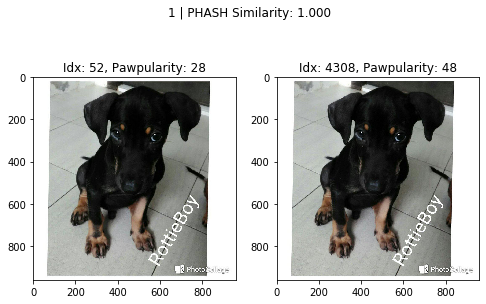

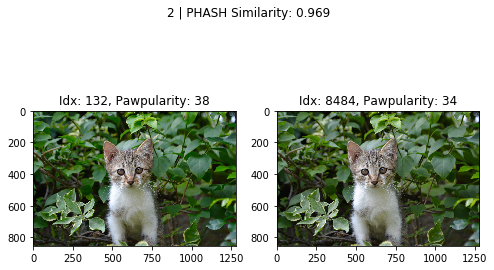

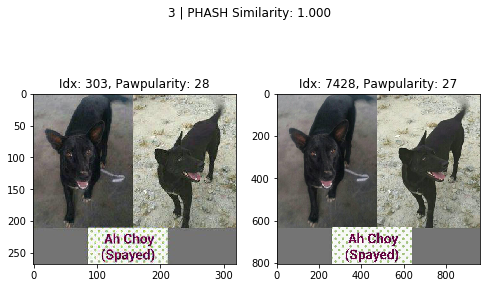

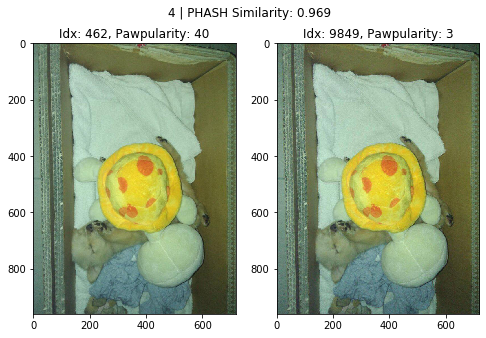

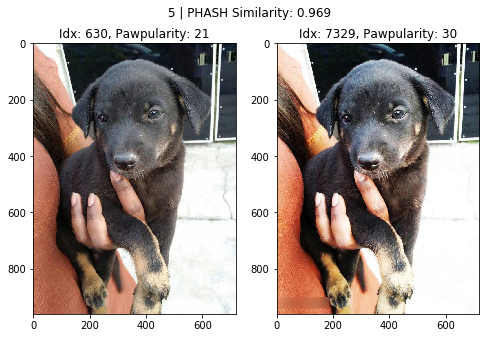

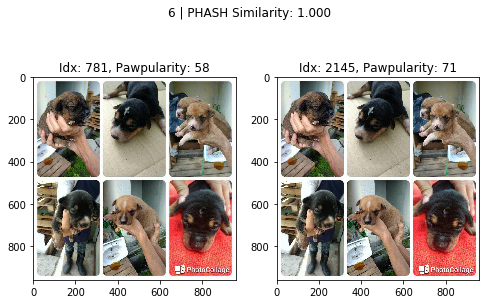

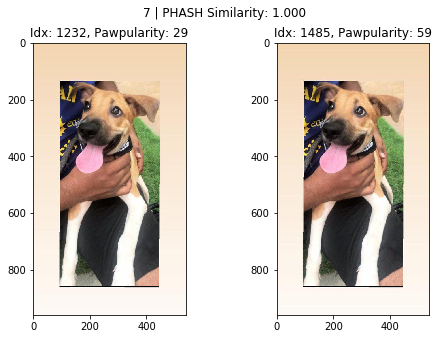

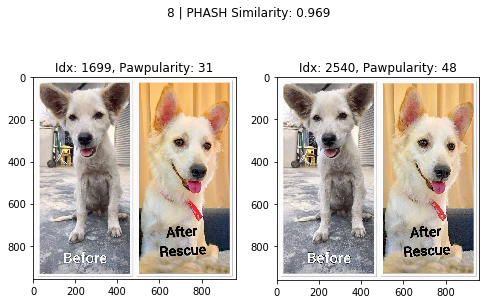

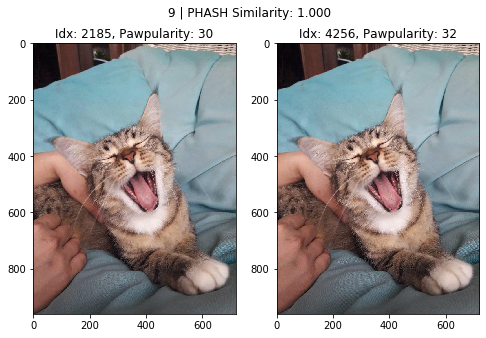

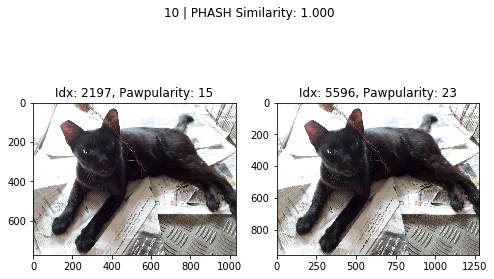

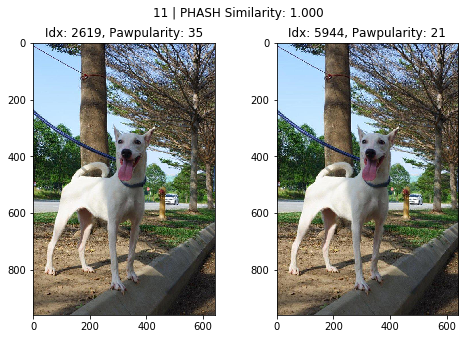

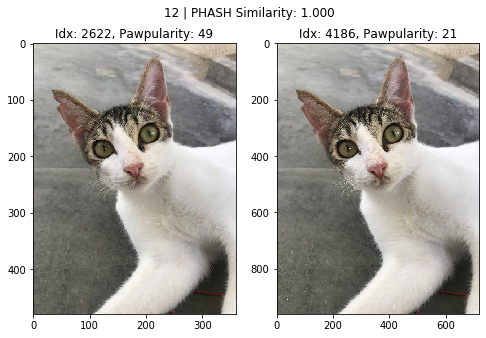

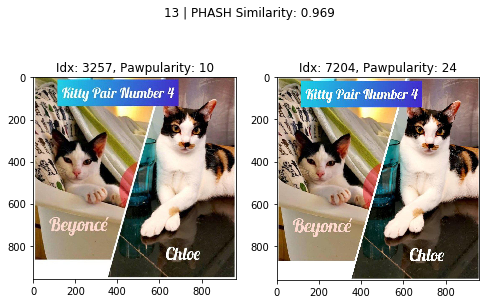

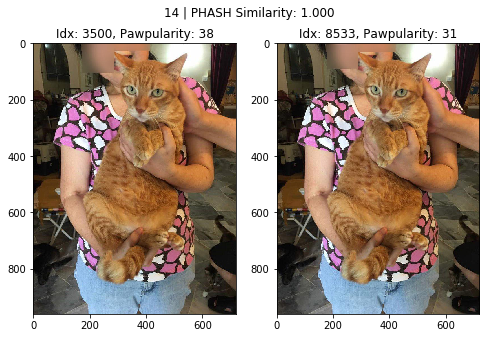

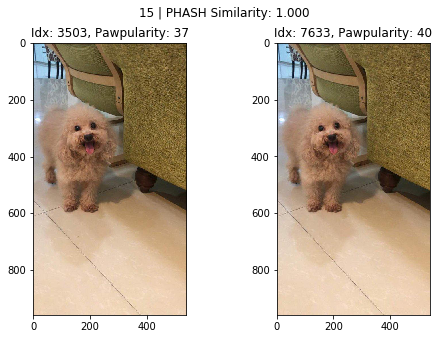

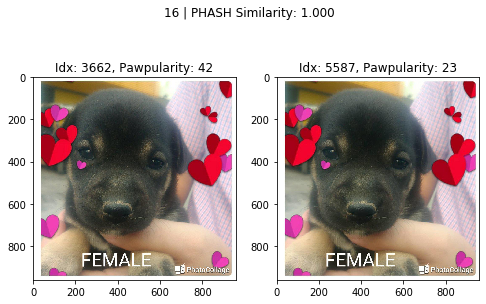

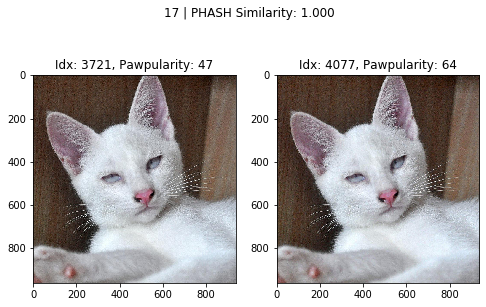

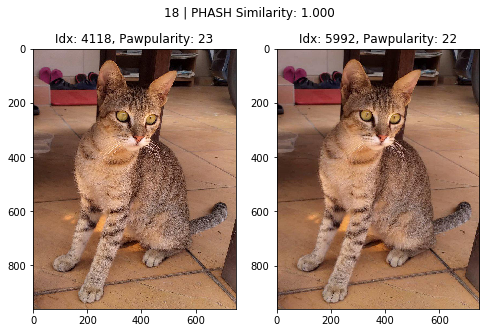

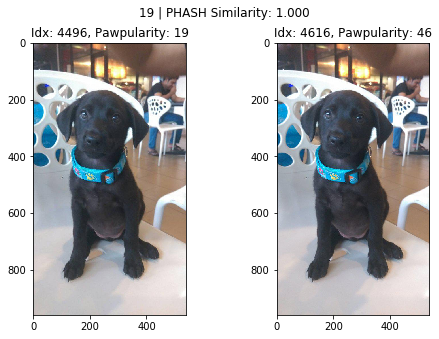

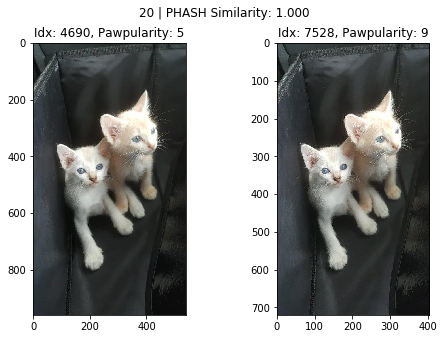

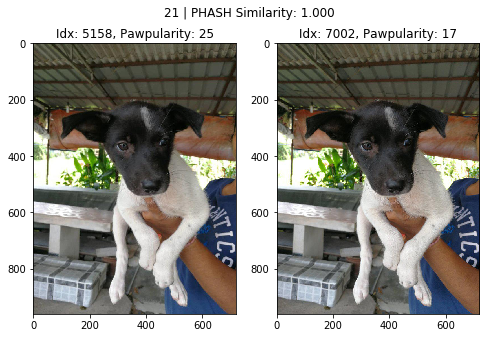

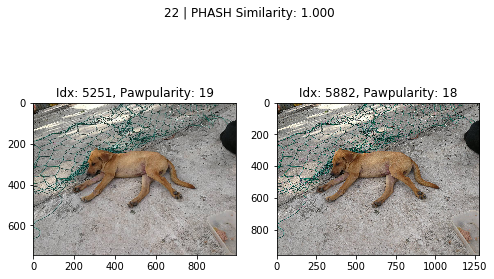

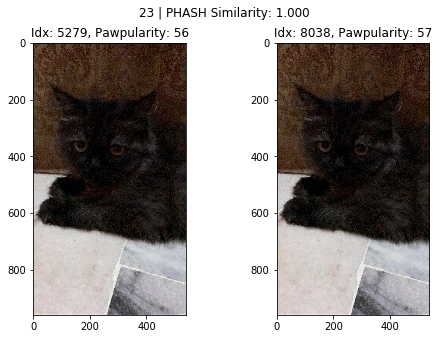

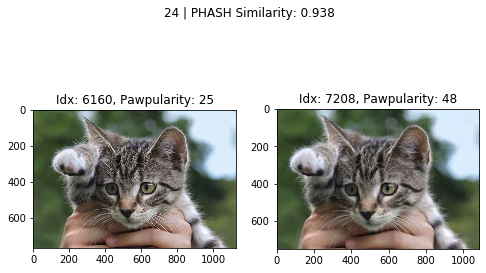

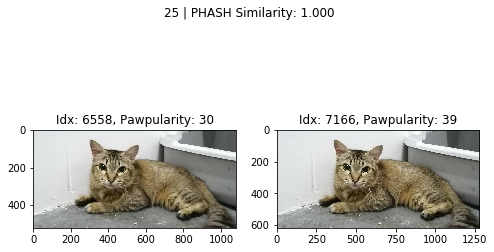

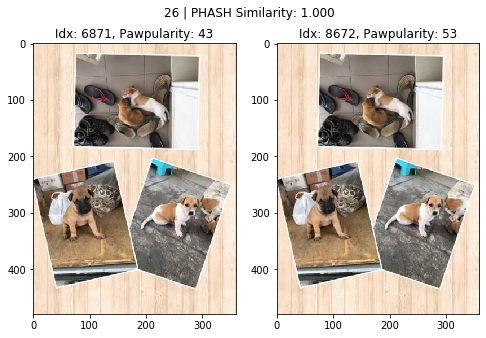

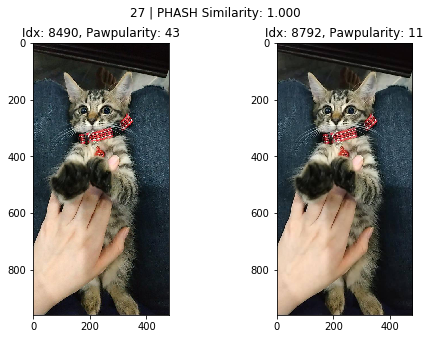

In [17]:
def find_similar_images(threshold=0.90):
    # Number of Duplicate Images Found
    duplicate_counter = 1
    # Indices of Duplicate Images
    duplicate_idxs = set()
    # For each image in the train dataset
    for idx, phash in enumerate(tqdm(train['phash'])):
        # Compute the similarity to all other images
        for idx_other, phash_other in enumerate(train['phash']):
            # Similarity score is imply the percentage of equal bits
            similarity = (phash ==phash_other).mean()
            # Prevent self comparison, threshold similarity and ignore repetetive duplicate detection
            if idx != idx_other and similarity > threshold and not(duplicate_idxs.intersection([idx, idx_other])):
                # Update Duplicate Indices
                duplicate_idxs.update([idx, idx_other])
                # Get DataFrame rows
                row = train.loc[idx]
                row_other = train.loc[idx_other]
                # Plot Duplicate Images
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
                ax[0].imshow(imageio.imread(row['file_path']))
                ax[0].set_title(f'Idx: {idx}, Pawpularity: {row["Pawpularity"]}')
                ax[1].imshow(imageio.imread(row_other['file_path']))
                ax[1].set_title(f'Idx: {idx_other}, Pawpularity: {row_other["Pawpularity"]}')
                plt.suptitle(f'{duplicate_counter} | PHASH Similarity: {similarity:.3f}')
                plt.show()
                # Increase Duplicate Counter
                duplicate_counter += 1
                
    # Return Indices of Duplicates
    return duplicate_idxs
    
duplicate_idxs = find_similar_images()

In [43]:
print(f'Found {len(duplicate_idxs)} Duplicate Images')
# Removing Duplicate records
train = train.drop(duplicate_idxs).reset_index(drop=True)

Found 54 Duplicate Images


In [44]:
# Check if images are correctly removed
# DataFrame size reduced by 27*2=54, from 9912 -> 9858
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9858 entries, 0 to 9857
Data columns (total 15 columns):
Id               9858 non-null object
Subject Focus    9858 non-null int64
Eyes             9858 non-null int64
Face             9858 non-null int64
Near             9858 non-null int64
Action           9858 non-null int64
Accessory        9858 non-null int64
Group            9858 non-null int64
Collage          9858 non-null int64
Human            9858 non-null int64
Occlusion        9858 non-null int64
Info             9858 non-null int64
Blur             9858 non-null int64
Pawpularity      9858 non-null int64
file_path        9858 non-null object
dtypes: int64(13), object(2)
memory usage: 1.1+ MB


In [20]:
widths = []
heights = []
ratios = []
for file_path in tqdm(train['file_path']):
    image = imageio.imread(file_path)
    h, w, _ = image.shape
    heights.append(h)
    widths.append(w)
    ratios.append(w / h)

  0%|          | 0/9858 [00:00<?, ?it/s]

Width Statistics


count    9858.000000
mean      804.522520
std       270.248645
min        90.000000
25%       676.000000
50%       720.000000
75%       960.000000
max      1280.000000
dtype: float64


Height Statistics


count    9858.000000
mean      904.418340
std       156.872505
min       113.000000
25%       909.250000
50%       960.000000
75%       960.000000
max      1280.000000
dtype: float64

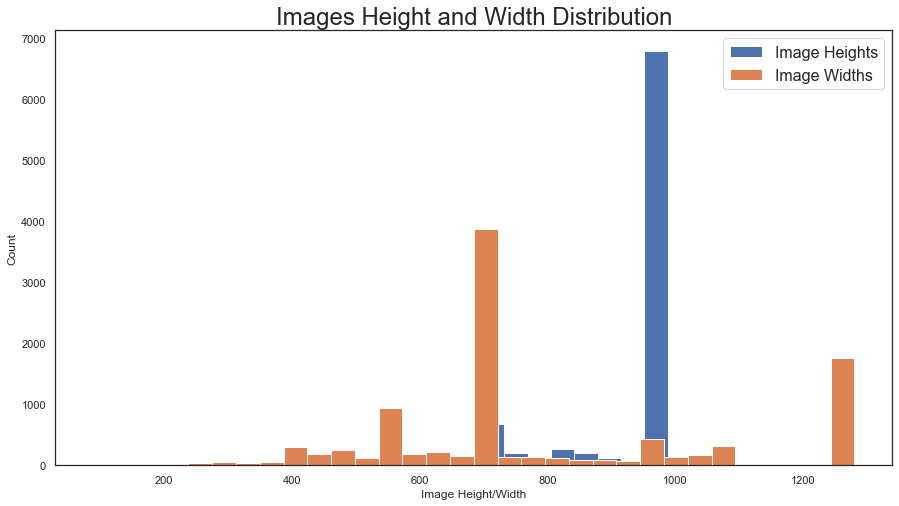

In [36]:
# Images Heigt and Width Distribution
print('Width Statistics')
display(pd.Series(widths).describe())
print()
print('Height Statistics')
display(pd.Series(heights).describe())

plt.figure(figsize=(15,8))
plt.title(f'Images Height and Width Distribution', size=24)
plt.hist(heights, bins=32, label='Image Heights')
plt.hist(widths, bins=32, label='Image Widths')
plt.legend(prop={'size': 16})
plt.xlabel("Image Height/Width")
plt.ylabel("Count")
#plt.show()
plt.savefig('fig2_1.pdf')

Ratio Statistics


count    9858.000000
mean        0.909790
std         0.337642
min         0.326042
25%         0.750000
50%         0.750000
75%         1.039428
max         3.152709
dtype: float64

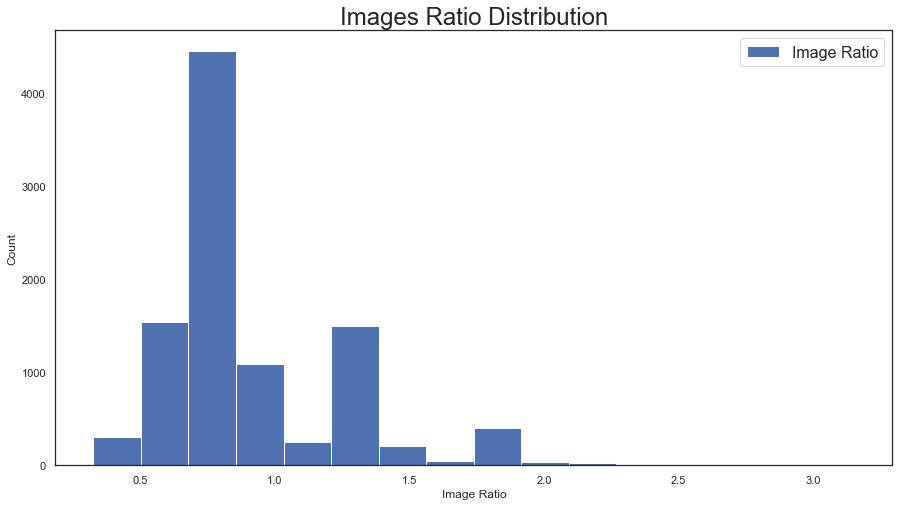

In [37]:
# Images Ratio Distribution
print('Ratio Statistics')
display(pd.Series(ratios).describe())
plt.figure(figsize=(15,8))
plt.title(f'Images Ratio Distribution', size=24)
plt.hist(ratios, bins=16, label='Image Ratio')
plt.legend(prop={'size': 16})
plt.xlabel("Image Ratio")
plt.ylabel("Count")
#plt.show()
plt.savefig('fig2_2.pdf')

## View 16 images with smallest and highest score

In [45]:
# Shows 16 images 
def show_batch_df(df, rows=4, cols=4):
    df = df.copy().reset_index()
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*4, rows*4))
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            img = imageio.imread(df.loc[idx, 'file_path'])
            axes[r, c].imshow(img)
            axes[r, c].set_title(f'{idx}, Score: {df.loc[idx, "Pawpularity"]}')

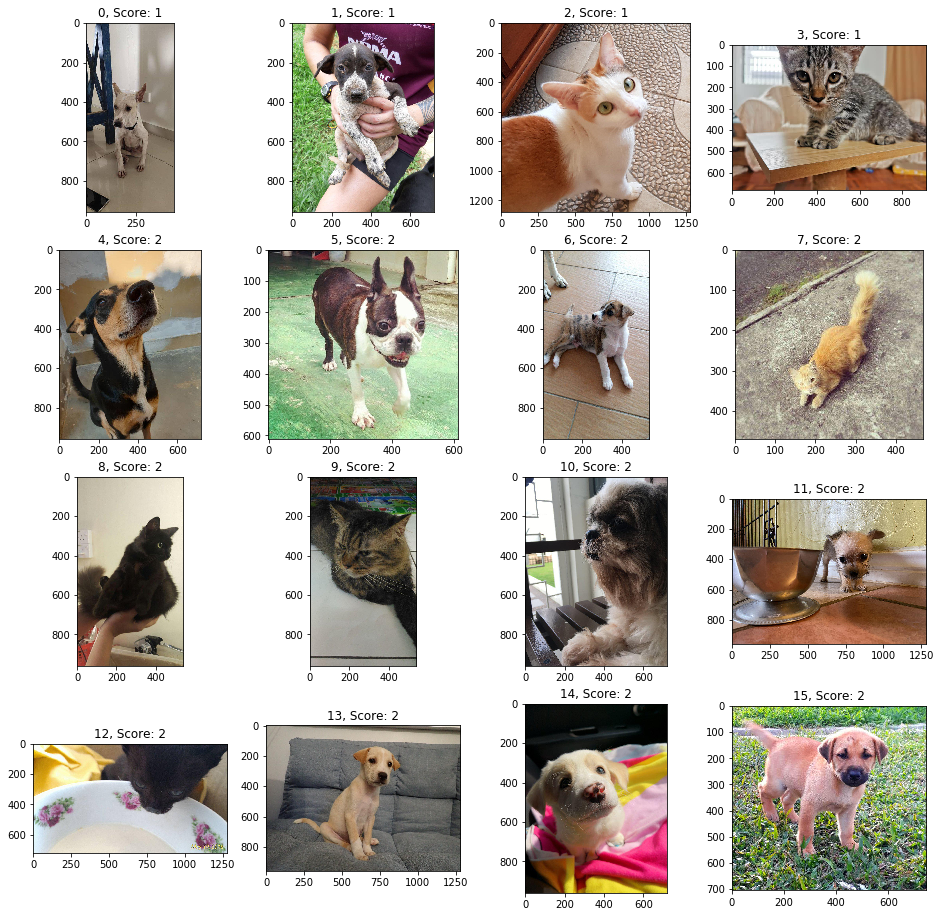

In [46]:
# Shows 16 images with smallest score
show_batch_df(train.sort_values('Pawpularity'))

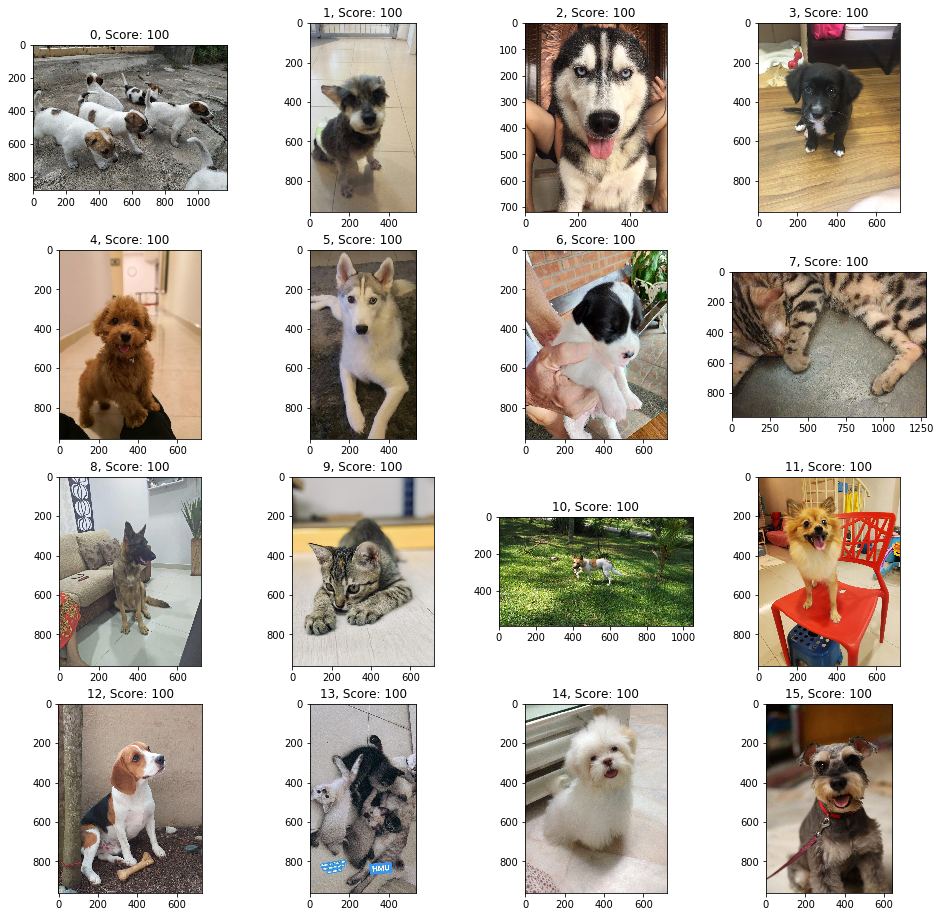

In [47]:
# Shows 16 images with highest score
show_batch_df(train.sort_values('Pawpularity', ascending=False))

# Model building

## 1. RandomForestRegressor, on the Metadata.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [49]:
predictor = train.columns[1:13]
X = train[predictor]

y = train["Pawpularity"].values
y = y/100

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("-"*80)
print("Train and test split sizes")
print("-"*80)
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_valid.shape}")
print(f"y_train : {y_train.shape[0]}")
print(f"y_test : {y_valid.shape[0]}")
print("-"*80)

--------------------------------------------------------------------------------
Train and test split sizes
--------------------------------------------------------------------------------
X_train : (7886, 12)
X_test : (1972, 12)
y_train : 7886
y_test : 1972
--------------------------------------------------------------------------------


In [50]:
rfr = RandomForestRegressor(random_state=8)
param_grid = {
            "n_estimators" : [500, 600, 700],
            "max_features" : ["log2", "sqrt", 0.33],
            "bootstrap"    : [True, False]
        }

grid_rfr = GridSearchCV(
    rfr,
    param_grid,
    cv = 5,
    verbose=1,
    n_jobs=-1)

best_rfr = grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


In [51]:
print("-"*60)
print("Best parameters for Random Forest model")
print("-"*60)
print(best_rfr.best_params_)
print("-"*60)

------------------------------------------------------------
Best parameters for Random Forest model
------------------------------------------------------------
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 700}
------------------------------------------------------------


<Figure size 864x576 with 0 Axes>

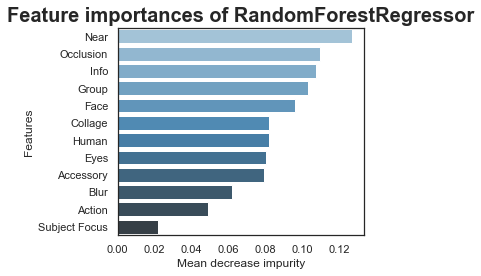

In [108]:
importances = best_rfr.best_estimator_.feature_importances_

feature_names = X_train.columns
forest_importances = pd.DataFrame(importances, columns=["FI"], index=feature_names)
forest_importances = forest_importances.sort_values("FI", ascending=False)

fig = plt.figure(figsize=(12,8))
fig, ax = plt.subplots()
sns.barplot(data=forest_importances, x = "FI", 
            y=forest_importances.index, ax=ax, 
            palette="Blues_d")
ax.set_title("Feature importances of RandomForestRegressor", 
             fontsize=20, fontweight='bold')
ax.set_xlabel("Mean decrease impurity")
ax.set_ylabel("Features")
fig.tight_layout()
#plt.show()
plt.savefig('fig3_1.pdf')

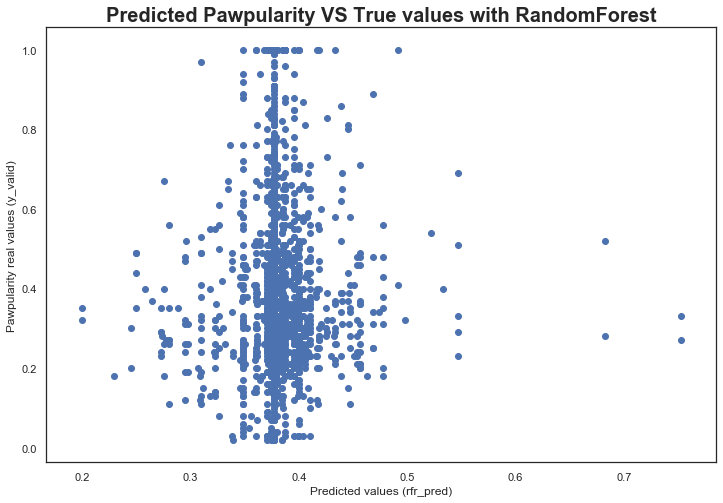

In [33]:
rfr_pred = best_rfr.predict(X_valid)
fig = plt.figure(figsize=(12,8))
plt.scatter(x=rfr_pred, y=y_valid)
plt.ylabel("Pawpularity real values (y_valid)")
plt.xlabel("Predicted values (rfr_pred)")
plt.title("Predicted Pawpularity VS True values with RandomForest", 
          fontsize=20, fontweight='bold')
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    """Numpy RMSE"""
    return np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Train RMSE: {rmse(y_train, best_rfr.predict(X_train)).round(4)}")
print(f"Test RMSE: {rmse(y_valid, best_rfr.predict(X_valid)).round(4)}")

Train RMSE: 0.2031
Test RMSE: 0.2064


## 2. Basic CNN model on image data

In [77]:
#modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
#get the data
train = pd.read_csv('data/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('data/petfinder-pawpularity-score/test.csv')
train.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

In [34]:
# Removing Duplicate records
print(f'Found {len(duplicate_idxs)} Duplicate Images')
train = train.drop(duplicate_idxs).reset_index(drop=True)

Found 54 Duplicate Images


In [35]:
#Use ID get the full image path. 
def train_id_to_path(x):
    return 'data/petfinder-pawpularity-score/train/' + x + ".jpg"
def test_id_to_path(x):
    return 'data/petfinder-pawpularity-score/test/' + x + ".jpg"

train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                    'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                  'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

#Add the .jpg extensions to the image file name
train["img_path"] = train["Id"].apply(train_id_to_path)
test["img_path"] = test["Id"].apply(test_id_to_path)
train.head()

Id  Pawpularity  \
0  0007de18844b0dbbb5e1f607da0606e0           63   
1  0009c66b9439883ba2750fb825e1d7db           42   
2  0013fd999caf9a3efe1352ca1b0d937e           28   
3  0018df346ac9c1d8413cfcc888ca8246           15   
4  001dc955e10590d3ca4673f034feeef2           72   

                                            img_path  
0  data/petfinder-pawpularity-score/train/0007de1...  
1  data/petfinder-pawpularity-score/train/0009c66...  
2  data/petfinder-pawpularity-score/train/0013fd9...  
3  data/petfinder-pawpularity-score/train/0018df3...  
4  data/petfinder-pawpularity-score/train/001dc95...

In [40]:
#Set the size of image 
image_height = 128
image_width = 128

#Preprocess the image to matrix
def path_to_eagertensor(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0    #normalize
    image = tf.image.resize(image, (image_height, image_width))
    return image

In [49]:
#get all the images in the training folder and put their tensors in a list
X = []
for img in train['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X.append(new_img_tensor)
    
print(type(X),len(X))

<class 'list'> 9858


In [21]:
X[0].shape

NameError: name 'X' is not defined

In [53]:
X = np.stack(X, axis = 0)
print(type(X),X.shape)

<class 'numpy.ndarray'> (9858, 128, 128, 3)


In [57]:
X[0,:,:,:]

array([[[0.47159067, 0.45982596, 0.5029632 ],
        [0.41024145, 0.39847675, 0.441614  ],
        [0.40422028, 0.39245558, 0.43559286],
        ...,
        [0.7097398 , 0.7188084 , 0.75973976],
        [0.70862824, 0.7216596 , 0.7536803 ],
        [0.69903684, 0.71080154, 0.7411937 ]],

       [[0.7035482 , 0.703058  , 0.7425188 ],
        [0.6748823 , 0.67439204, 0.7138528 ],
        [0.6542461 , 0.6537559 , 0.6932167 ],
        ...,
        [0.6296588 , 0.6511336 , 0.6355479 ],
        [0.65810263, 0.6649194 , 0.66986734],
        [0.66543925, 0.6691157 , 0.67695886]],

       [[0.74648535, 0.75825006, 0.7935442 ],
        [0.7377882 , 0.7495529 , 0.784847  ],
        [0.75046915, 0.76223385, 0.79752797],
        ...,
        [0.5839049 , 0.67900294, 0.5131482 ],
        [0.58567905, 0.65895474, 0.50839657],
        [0.6061418 , 0.67550457, 0.51447517]],

       ...,

       [[0.5648438 , 0.5652057 , 0.5260905 ],
        [0.5414331 , 0.54535466, 0.5139821 ],
        [0.5450971 , 0

In [52]:
#X = np.array(X)
#print(type(X),X.shape)

In [54]:
#get all the images in the test folder and put their tensors in a list
X_submission = []
for img in test['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X_submission.append(new_img_tensor)
    
print(type(X_submission),len(X_submission))
#X_submission = np.array(X_submission)
X_submission = np.stack(X_submission, axis = 0)
print(type(X_submission),X_submission.shape)

<class 'list'> 8
<class 'numpy.ndarray'> (8, 128, 128, 3)


In [55]:
#target variable
y = train['Pawpularity']
print(type(y))

<class 'pandas.core.series.Series'>


In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8872, 128, 128, 3) (986, 128, 128, 3) (8872,) (986,)


In [81]:
inputs=keras.Input(shape=(image_width,image_height,3))
x=inputs
x=keras.layers.Conv2D(filters=16,kernel_size=3,strides=2,padding='same',activation='relu')(x)
x=keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x=keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation='relu')(x)
x=keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x=keras.layers.Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation='relu')(x)
x=keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x=keras.layers.Conv2D(filters=128,kernel_size=3,strides=2,padding='same',activation='relu')(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(128, activation = "relu")(x)
x=keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1)(x)  #default activation function is linear.
model = tf.keras.Model(inputs=inputs, outputs=output)

In [82]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 64)         

In [83]:
#compile the model
model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae", "mape"])

In [84]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-9)
callbacks = [early_stop,reduce_lr]

In [61]:
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")


In [85]:
history = model.fit(x_train,y_train, epochs=25,batch_size=32,
                    validation_data = (x_test,y_test),callbacks=callbacks)

Epoch 1/25
278/278 [==============================] - 12s 45ms/step - loss: 544.2248 - rmse: 23.3286 - mae: 17.2838 - mape: 80.7307 - val_loss: 454.7904 - val_rmse: 21.3258 - val_mae: 16.9684 - val_mape: 86.5899
Epoch 2/25
278/278 [==============================] - 10s 37ms/step - loss: 455.4630 - rmse: 21.3416 - mae: 15.9775 - mape: 79.7862 - val_loss: 413.1900 - val_rmse: 20.3271 - val_mae: 15.0088 - val_mape: 70.2498
Epoch 3/25
278/278 [==============================] - 10s 36ms/step - loss: 454.2074 - rmse: 21.3121 - mae: 15.9234 - mape: 79.2966 - val_loss: 431.2659 - val_rmse: 20.7669 - val_mae: 16.4591 - val_mape: 84.2775
Epoch 4/25
278/278 [==============================] - 10s 38ms/step - loss: 449.0757 - rmse: 21.1914 - mae: 15.8256 - mape: 79.5686 - val_loss: 413.1380 - val_rmse: 20.3258 - val_mae: 14.5514 - val_mape: 64.8819
Epoch 5/25
278/278 [==============================] - 11s 38ms/step - loss: 447.0410 - rmse: 21.1433 - mae: 15.7971 - mape: 79.4938 - val_loss: 409.5883

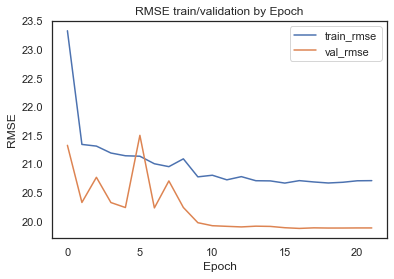

In [102]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
#plt.xticks(range(0,60))
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
plt.savefig('fig3_2.pdf')

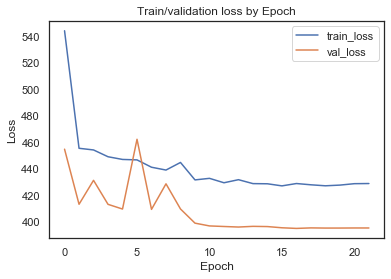

In [103]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
#plt.xticks(range(0,60))
plt.title("Train/validation loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig('fig3_3.pdf')

In [88]:
cnn_pred=model.predict(X_submission)

In [ ]:
cnn=pd.DataFrame()
cnn['Id']=test['Id']
cnn['Pawpularity']=cnn_pred
cnn.to_csv('submission.csv',index=False)

## 3. Pretrained Model

In [18]:
#modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [58]:
#get the data
train = pd.read_csv('data/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('data/petfinder-pawpularity-score/test.csv')
train.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

In [59]:
# Removing Duplicate records
print(f'Found {len(duplicate_idxs)} Duplicate Images')
train = train.drop(duplicate_idxs).reset_index(drop=True)

Found 54 Duplicate Images


In [60]:
#Use ID get the full image path. 
def train_id_to_path(x):
    return 'data/petfinder-pawpularity-score/train/' + x + ".jpg"
def test_id_to_path(x):
    return 'data/petfinder-pawpularity-score/test/' + x + ".jpg"

train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                    'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                  'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

#Add the .jpg extensions to the image file name
train["img_path"] = train["Id"].apply(train_id_to_path)
test["img_path"] = test["Id"].apply(test_id_to_path)
train.head()

Id  Pawpularity  \
0  0007de18844b0dbbb5e1f607da0606e0           63   
1  0009c66b9439883ba2750fb825e1d7db           42   
2  0013fd999caf9a3efe1352ca1b0d937e           28   
3  0018df346ac9c1d8413cfcc888ca8246           15   
4  001dc955e10590d3ca4673f034feeef2           72   

                                            img_path  
0  data/petfinder-pawpularity-score/train/0007de1...  
1  data/petfinder-pawpularity-score/train/0009c66...  
2  data/petfinder-pawpularity-score/train/0013fd9...  
3  data/petfinder-pawpularity-score/train/0018df3...  
4  data/petfinder-pawpularity-score/train/001dc95...

In [116]:
#Set the size of image 
image_size = 224

#Preprocess the image to matrix
def path_to_eagertensor(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0    #normalize
    image = tf.image.resize(image, (image_size, image_size))
    #image = tf.cast(image, tf.int32) 
    #return image
    return tf.keras.applications.efficientnet.preprocess_input(image)

In [117]:
#get all the images in the training folder and put their tensors in a list
X = []
for img in train['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X.append(new_img_tensor)
    
print(type(X),len(X))

<class 'list'> 9858


In [102]:
example_image = path_to_eagertensor('data/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg')

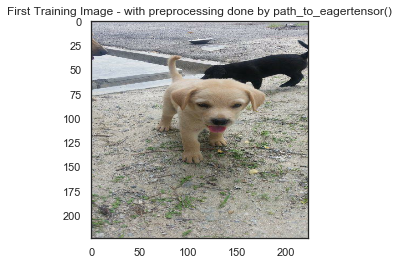

In [103]:
plt.imshow(example_image)
plt.title('First Training Image - with preprocessing done by path_to_eagertensor()') 
plt.show()

In [118]:
X = np.stack(X, axis = 0)
print(type(X),X.shape)

<class 'numpy.ndarray'> (9858, 224, 224, 3)


In [119]:
#get all the images in the test folder and put their tensors in a list
X_submission = []
for img in test['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X_submission.append(new_img_tensor)
    
print(type(X_submission),len(X_submission))
#X_submission = np.array(X_submission)
X_submission = np.stack(X_submission, axis = 0)
print(type(X_submission),X_submission.shape)

<class 'list'> 8
<class 'numpy.ndarray'> (8, 224, 224, 3)


In [120]:
#target variable
y = train['Pawpularity']
print(type(y))

<class 'pandas.core.series.Series'>


In [121]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8872, 224, 224, 3) (986, 224, 224, 3) (8872,) (986,)


In [122]:
# Loading pretrained EfficientNet
img_model = "data/EfficientNetB0.h5"
effnet = tf.keras.models.load_model(img_model, compile=False)
# Layers of efficientnet will not be trained
effnet.trainable = False

In [123]:
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [128]:
model = Sequential([
    Input(shape=(image_size, image_size, 3)),
    effnet,
    BatchNormalization(),
    Dropout(0.2),
    Dense(units = 32, activation="relu"),
    Dense(units = 1)  #default activation function is linear.
])

In [129]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                40992     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 4,095,716
Trainable params: 43,585
Non-trainable params: 4,052,131
_________________________________________________________________


In [130]:
# Early stopping helps as it stops training if val_loss(validation score) does not decrease.
LEARNING_RATE = 1e-3
DECAY_STEPS = 100
DECAY_RATE = 0.96
EPOCHS = 30
PATIENCE = 5

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE,
    staircase=True)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [131]:
# To monitor validation loss and stop the training.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(x_train,y_train, validation_data=(x_test,y_test),
                          epochs=EPOCHS, callbacks=[early_stop],
                          use_multiprocessing=True, workers=-1)

Epoch 1/30
278/278 [==============================] - 412s 1s/step - loss: 667.5247 - root_mean_squared_error: 25.8365 - val_loss: 617.9160 - val_root_mean_squared_error: 24.8579
Epoch 2/30
278/278 [==============================] - 407s 1s/step - loss: 452.0270 - root_mean_squared_error: 21.2609 - val_loss: 454.9333 - val_root_mean_squared_error: 21.3292
Epoch 3/30
278/278 [==============================] - 409s 1s/step - loss: 442.1754 - root_mean_squared_error: 21.0280 - val_loss: 419.1189 - val_root_mean_squared_error: 20.4724
Epoch 4/30
278/278 [==============================] - 434s 2s/step - loss: 440.9556 - root_mean_squared_error: 20.9989 - val_loss: 405.6402 - val_root_mean_squared_error: 20.1405
Epoch 5/30
278/278 [==============================] - 434s 2s/step - loss: 440.2989 - root_mean_squared_error: 20.9833 - val_loss: 396.9070 - val_root_mean_squared_error: 19.9225
Epoch 6/30
278/278 [==============================] - 436s 2s/step - loss: 438.9727 - root_mean_squared_e